In [1]:
import numpy as np
import matplotlib.pyplot as plt
from gen_frac_diff_trajectories import fractional_diffusion
from scipy.io import loadmat
from scipy.special import gamma
from numpy import cos, sin, pi
# from utils import estimate_frac_diff_2
from utils import *

# Generate artificial trajectories

In [2]:
alpha_ = 2;beta_ = 1;theta_ = 0;D_ = 1;L = 1e3;M = int(1e4)
traj = fractional_diffusion(alpha_, beta_, theta_, D_, L, M, use_parallel=True, do_save=False)

In [32]:
data_raw = loadmat('data/sim_D_1.00_A_2.00_B_1.00_theta_0.00_N_30000_M_10000_L_1000.mat')
traj = {'x':data_raw['xnt'], 'T':np.squeeze(data_raw['T'])}

In [3]:
delta_use = 0.001
moment_p = np.mean(np.power(np.abs(traj['x']), delta_use), axis=1)
moment_p_ther = np.power(traj['T'], delta_use*beta_/alpha_)*(gamma(1 - delta_use/alpha_) * gamma(1 + delta_use/alpha_)
                                                            *cos(np.pi*delta_use*theta_/2/alpha_)/gamma(1 - delta_use)
                                                            /gamma(1 + delta_use*beta_/alpha_)/cos(delta_use*pi/2))

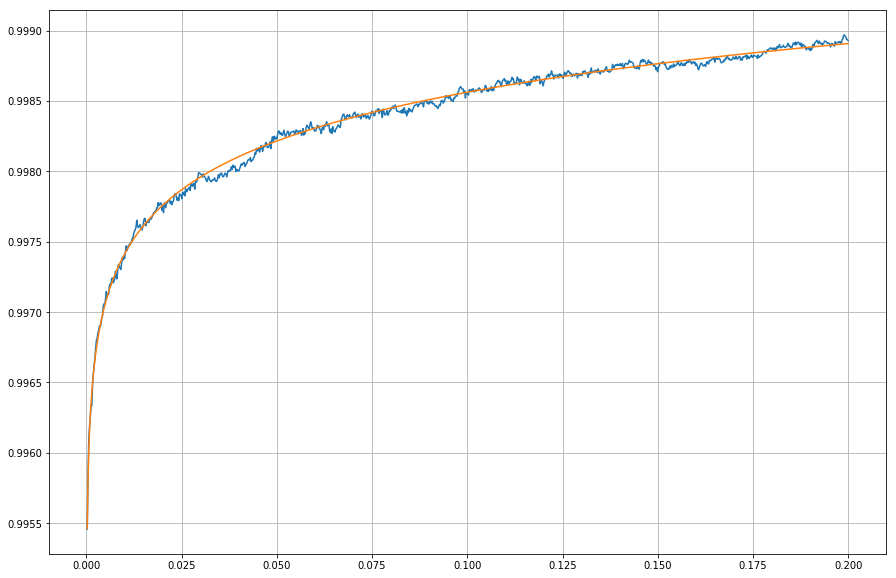

In [4]:
plt.figure(figsize=(15,10))
plt.plot(traj['T'][1:],moment_p[1:])
plt.plot(traj['T'][1:],moment_p_ther[1:])
plt.grid()
plt.show()

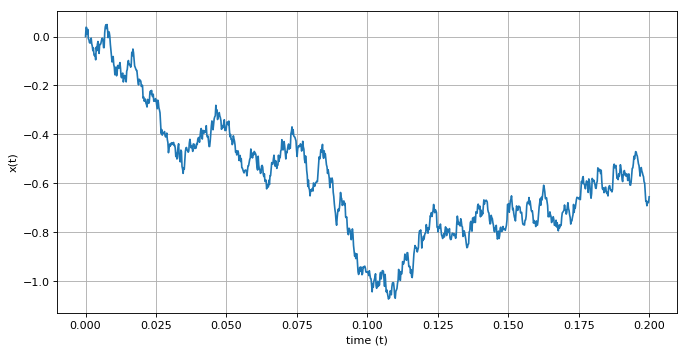

In [3]:
# plot a sample trajectory
plt.figure(figsize=(10, 5), dpi=80)
plt.plot(traj['T'], traj['x'][:,90])
plt.xlabel('time (t)')
plt.ylabel('x(t)')
plt.grid()
plt.show()

# Estimate fractional diffusion PDE parameters
## Approach-1 (using sinc inverse)

## Approach-2 (using log covariates)

In [8]:
is_feasible, alpha_hat, beta_hat, theta_hat, D_hat = estimate_frac_diff_2(traj['x'], traj['T'])
if is_feasible:
    print('Estimated values of (alpha, beta, theta, D) = (%f, %f, %f, %f)'%(alpha_hat, beta_hat, theta_hat, D_hat))

Estimated values of (alpha, beta, theta, D) = (1.999648, 1.004100, 0.037798, 0.995128)


### We now study the behavior of the Algorithm-2 with varying number of trajectories

In [ ]:
%%time
results = get_appended_results_(M, traj, num_trials=35, num_points=200)
param_fin = np.array(results)

In [89]:
ALPHA = np.squeeze(param_fin[:,0,:])

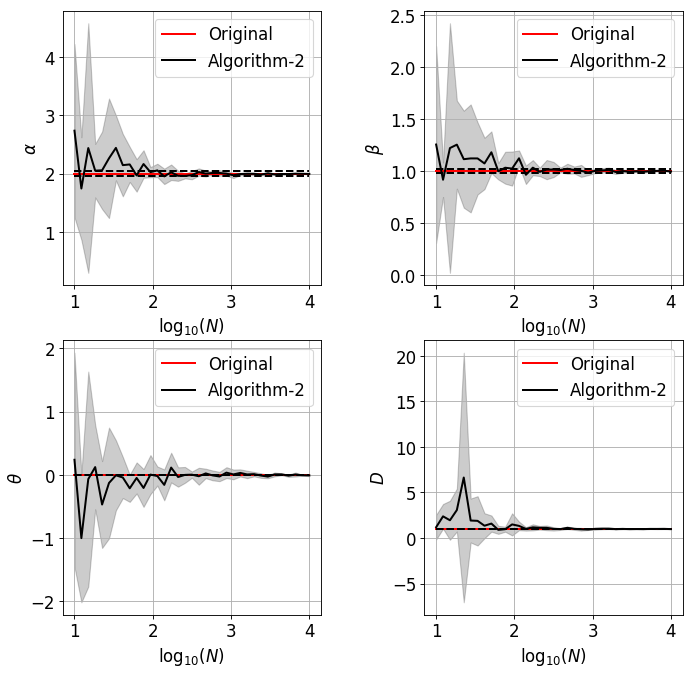

In [35]:
color = ['b', 'k', 'r', 'goldenrod', 'k', 'm' , 'xkcd:Purple', 'C1', 'C2', 'xkcd:Brown', 'xkcd:navy blue', 'k']
linestyle = ['solid', 'solid', 'solid', 'solid', 'dashed', 'solid']

f = plt.figure(figsize=(10,10), dpi=80)
# f = plt.figure(figsize=(17,10), dpi=80)
plt.rc('font', size=15)
plt.rc('legend', fontsize=15)
legend_name = ['Algorithm-1','Algorithm-2', 'Algo-2-mgf']
frac_param_list = ['alpha', 'beta', 'theta', 'D']
y_label_list = [r'$\alpha$', r'$\beta$', r'$\theta$', r'$D$']
ax_all = []
x = np.linspace(1, np.log10(M), 35)
plt.subplots_adjust(wspace= 0.4)
params_orig = np.array([alpha_, beta_, theta_, D_])
for i, param_name in enumerate(frac_param_list):
    ax_curr = plt.subplot(2, 2, i+1)
    ax_all.append(ax_curr)
    plt.plot(x, np.ones((np.size(x),))*params_orig[i], color='r', linewidth = 1.8, label = 'Original')
    plt.plot(x, np.ones((np.size(x),))*params_orig[i]*1.02, color='k', linewidth = 1.8, linestyle = 'dashed')
    plt.plot(x, np.ones((np.size(x),))*params_orig[i]*0.98, color='k', linewidth = 1.8, linestyle = 'dashed')
    plt.xlabel('$\log_{10}(N)$', fontsize=15)
    plt.ylabel(y_label_list[i], fontsize=15)

i = 1
for j, frac_param in enumerate(frac_param_list):
    plt.sca(ax_all[j])
    y_mean = np.mean(param_fin[:,j,:],axis=0)
    y_std = np.std(param_fin[:,j,:],axis=0)
    p = ax_all[j].plot(x, y_mean, color = color[i], linewidth = 1.8, label = legend_name[i])
    plt.fill_between(x, y_mean - y_std, y_mean + y_std, color = p[0].get_color(), alpha = 0.2)
    plt.grid()
    plt.legend()
plt.show()

In [65]:
params_orig = np.array([alpha_, beta_, theta_, D_])

In [64]:
alpha_ = 0.25;beta_ = 0.25;theta_ = 0.25;D_ = 1;L = 1e3;M = int(1e4)

In [38]:
%%time
num_trials = 35
M = int(M)
M_try = np.floor(np.logspace(0, np.log10(M), num_trials)).astype('int')
num_points = 200
alpha_try = np.zeros((num_trials, num_points))
beta_try = np.zeros((num_trials, num_points))
theta_try = np.zeros((num_trials, num_points))
D_try = np.zeros((num_trials, num_points))
for p in range(num_points):
    for t in range(num_trials):
        max_try = 20
        ctr = 0
        M_use = M_try[t]
        while(ctr<max_try):
            random_traj_index = np.random.choice(M, M_use).astype('int')
            x_use = traj['x'][:,random_traj_index]
            is_feasible, alpha_hat, beta_hat, theta_hat, D_hat = estimate_frac_diff_2(x_use, traj['T'])
            if not is_feasible:
                ctr += 1
#                 print('infeasible soln at (p, t) = (%d,%d), continuing with more permutations...'%(p, t))
                continue
            alpha_try[t, p] = alpha_hat
            beta_try[t, p] = beta_hat
            theta_try[t, p] = theta_hat
            D_try[t, p] = D_hat
            break
#     print('successful for (p) = (%d)'%(p))

CPU times: user 2h 47min 46s, sys: 5min 50s, total: 2h 53min 37s
Wall time: 35min 39s


In [45]:
%%time
num_trials = 35
M = int(M)
M_try = np.floor(np.logspace(0, np.log10(M), num_trials)).astype('int')
num_points = 200
alpha_try = np.zeros((num_trials, num_points))
beta_try = np.zeros((num_trials, num_points))
theta_try = np.zeros((num_trials, num_points))
D_try = np.zeros((num_trials, num_points))
num_processes = cpu_count()
pool = Pool(processes=num_processes)
results = []
for p in range(num_points):
    results.append(apply_async(pool, get_trials_, (num_trials, M, M_try, traj['x'], traj['T'])))
results = [p.get() for p in results]

CPU times: user 24.5 s, sys: 51.3 s, total: 1min 15s
Wall time: 4min 34s
